<a href="https://colab.research.google.com/github/Norceis/radar-project/blob/main/radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, concatenate, Activation, Concatenate, Conv2DTranspose, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [4]:
with open('data_slices_mulitchannel.pickle', 'rb') as f:
    x, y = pickle.load(f)

classes = [
            'KUBA',
            'OSKAR',
            'RAFAL',
            'BARTEK']

print(x.shape, y.shape)

# skip classes 0 and 4
x = x[np.where(y != 0)]
y = y[np.where(y != 0)]

x = x[np.where(y != 4)]
y = y[np.where(y != 4)]

# change class 5 to 4
y[np.where(y == 5)] = 4
y = y - 1

print(x.shape, y.shape)

y = to_categorical(y, num_classes=len(classes))

print(x.shape, y.shape)

img_shape = x[0].shape

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

(8413, 54, 216, 4) (8413,)
(5609, 54, 216, 4) (5609,)
(5609, 54, 216, 4) (5609, 4)


In [5]:
model = Sequential()

model.add(Conv2D(16, (3,3), padding='same', input_shape=img_shape))
model.add(MaxPooling2D())
model.add(LeakyReLU())
model.add(Dropout(0.3))

model.add(Conv2D(32, (3,3), strides=(2, 2), padding='same'))
model.add(MaxPooling2D())
model.add(LeakyReLU())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
model.add(MaxPooling2D())
model.add(LeakyReLU())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU())
model.add(Dropout(0.3))
model.add(Dense(len(classes), activation='softmax'))
model.summary()

slice = Input(shape=img_shape)
pred = model(slice)
radar_model = Model(slice, pred)


METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy')
]


# optimizer = Adam(0.0002, 0.5)
radar_model.compile(loss='categorical_crossentropy',
                          optimizer='Adam',
                        metrics=METRICS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 216, 16)       592       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 108, 16)      0         
 )                                                               
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 27, 108, 16)       0         
                                                                 
 dropout (Dropout)           (None, 27, 108, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 54, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 27, 32)        0         
 2D)                                                    

In [6]:
radar_model.fit(x_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
141/141 [==============================] - 17s 75ms/step - loss: 1.3729 - accuracy: 0.7504
Epoch 2/20
141/141 [==============================] - 10s 68ms/step - loss: 1.3139 - accuracy: 0.7541
Epoch 3/20
141/141 [==============================] - 11s 78ms/step - loss: 1.2684 - accuracy: 0.7613
Epoch 4/20
141/141 [==============================] - 12s 86ms/step - loss: 1.2318 - accuracy: 0.7655
Epoch 5/20
141/141 [==============================] - 11s 76ms/step - loss: 1.2013 - accuracy: 0.7721
Epoch 6/20
141/141 [==============================] - 11s 79ms/step - loss: 1.1779 - accuracy: 0.7759
Epoch 7/20
141/141 [==============================] - 11s 80ms/step - loss: 1.1418 - accuracy: 0.7796
Epoch 8/20
141/141 [==============================] - 11s 75ms/step - loss: 1.1179 - accuracy: 0.7837
Epoch 9/20
141/141 [==============================] - 11s 80ms/step - loss: 1.0930 - accuracy: 0.7884
Epoch 10/20
141/141 [==============================] - 10s 74ms/step - loss: 1.060

In [7]:
radar_model.evaluate(x_test, y_test)


36/36 [==============================] - 1s 21ms/step - loss: 1.1098 - accuracy: 0.7861


[1.1098438501358032, 0.7860962748527527]

In [8]:
np.unique(y, return_counts=True)

(array([0., 1.], dtype=float32), array([42065,  8413], dtype=int64))

36/36 [==============================] - 1s 17ms/step


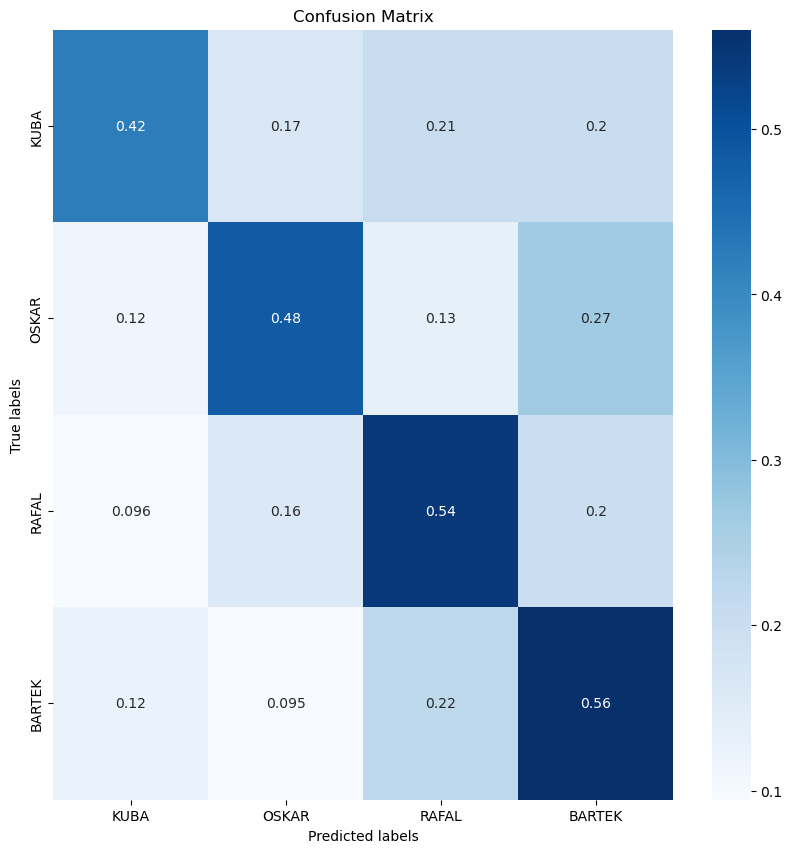

In [8]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = radar_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)
plt.show()